### BÖLÜM 1

In [1]:
import cv2

In [2]:
import numpy as np
 

In [3]:
img = cv2.imread("people.jpg")
#print(type(img))
img

#nesnemi okuttum

 
img_width = img.shape[1]   # 640
img_height = img.shape[0]  #  427

img.shape

(427, 640, 3)

### BÖLÜM 2

In [4]:
# modele verebilmem için  resmimi blob formatına çevirdim 
# 1/255,  en optimal faktör
# (416,416) indirdiğim pretrained modelin boyutu ne ise onu vermeliyiz
# swapRB = fotografımı rgb formatıına cevirdi


img_blob = cv2.dnn.blobFromImage(img, 1/255, (416,416), swapRB = True, crop = False)

In [5]:
#  daha onceden tanımlanmış 80 tane label var  

labels = [          "person","bicycle","car","motorcycle","airplane","bus","train","truck","boat",
                    "trafficlight","firehydrant","stopsign","parkingmeter","bench","bird","cat",
                    "dog","horse","sheep","cow","elephant","bear","zebra","giraffe","backpack",
                    "umbrella","handbag","tie","suitcase","frisbee","skis","snowboard","sportsball",
                    "kite","baseballbat","baseballglove","skateboard","surfboard","tennisracket",
                    "bottle","wineglass","cup","fork","knife","spoon","bowl","banana","apple",
                    "sandwich","orange","broccoli","carrot","hotdog","pizza","donut","cake","chair",
                    "sofa","pottedplant","bed","diningtable","toilet","tvmonitor","laptop","mouse",
                    "remote","keyboard","cellphone","microwave","oven","toaster","sink","refrigerator",
                    "book","clock","vase","scissors","teddybear","hairdrier","toothbrush"   ]

In [6]:
labels[0]

'person'

In [7]:
# her bir label için farklı renkler vereceğim

colors  = ["0, 255, 255", "0, 0, 255", "255, 0,0", "255, 255, 0 ", "0, 255, 0"]
# bunlar str oldugu için bunları integera cevirmem gerekiyor,
colors  = [np.array(color.split(",")).astype("int") for color in colors]
# bunları tek bir array içine almak istiyorum 
colors  = np.array(colors) 
# colors matrisimdeki sayıları artıracağım ( parantezi içindeki sayı kadar sütun ve sayı ekler)
colors =  np.tile(colors,(18,1))
    
    

### BÖLÜM 3 

In [8]:
#--------------- artık algoritmamızı yazabiliriz

model  = cv2.dnn.readNetFromDarknet("yolov3.cfg","yolov3.weights")

# modelimin içindeki tüm layerlarımı çekmem gerekiyor detection için

layers = model.getLayerNames()

# benim işlem yapmak istediğim ise sadece detection yapılanlar
# ancak benım bna ulaşmam gerekiyor 256 tane katman var ve hangisi output onu arıyorum 
#  model.getUnconnectedOutLayers() bunu bulmama yarıyor ancak index 0'dan başladıgı için -1 yapmam gerekiyor

output_layer = [layers[layer-1] for layer in model.getUnconnectedOutLayers()]

""" output_layer =[]
for i in model.getUnconnectedOutLayers() : 
    output_layer.append(int(i-1)) """
    
# şimdi input olan blobumu verebilirim

model.setInput(img_blob) #  4 boyutlu format

detection_layers = model.forward(output_layer)
 

### BÖLÜM 3.1 -Non-Maximum Suppression

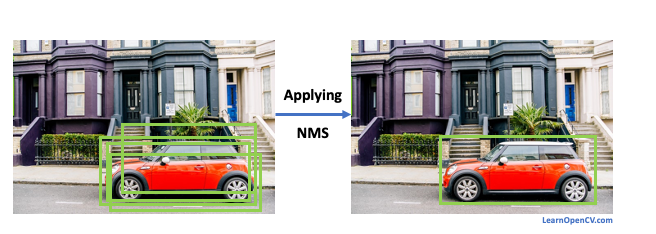

In [9]:
#############  NON-MAXIMUM SUPPRESSION - OPERATION 1 ###############
ids_list = []
boxes_list = []
confidences_list = []
########################  END OF OPERATION 1 ########################

### 4.BÖLÜM

In [10]:

for detection_layer in detection_layers: #3 arrayın içinde geziyorum
  for object_detection in detection_layer:

    scores =  object_detection[5:] # bu skorlardan en büyüğü benim nesnem olacak
    predicted_id = np.argmax(scores)
    confidence = scores[predicted_id] #GÜVEN SKORUMun tutulduğu yer

    if confidence > 0.35 : # güven skorum bu ddeğerden büyükse çizsin
      label = labels[predicted_id] # ancak bu hangi label onu bulmam gerekiyor
      bounding_box = object_detection[0:4] * np.array([img_width, img_height, img_width, img_height]) #en ve boy ile genişletiyorum 
        # ilk 4 değerim benım için yeterli değil bu yüzden w,h değerleri ile çarpmıp büyütmem gerekiyor
      (box_center_x, box_center_y, box_width, box_height) = bounding_box.astype("int")
        #  dikdörtgen çizebilmem için buna ihtiyacım var 
        
      start_x = int(box_center_x - (box_width/2)) #baslangıc ve
      start_y = int(box_center_y - (box_height/2)) 

      #############      NON-MAXIMUM SUPPRESSION - OPERATION 2 ###############   
      # listelerin içini dolduracağım
      ids_list.append(predicted_id)
      confidences_list.append(float(confidence))  # float alıyorum değerlerimin büyük çıkmasını istemiyorum
      boxes_list.append([start_x,start_y, int(box_width),int(box_height)])

      #############--------------- END OF OPERATION 2 ------- ###############
        
 





In [11]:

#############  NON-MAXIMUM SUPPRESSION - OPERATION - 3 ###############          
# en yüksek güvenirliliğe sahip dikdörtgenlerin id lerini döndürür

max_ids = cv2.dnn.NMSBoxes(boxes_list, confidences_list, 0.5, 0.4) # 0,5 güven skoru, 0.4 threshold değeri
for maxId in max_ids:
    box = boxes_list[maxId]
    start_x = box[0]
    start_y = box[1]
    box_width = box[2]
    box_height = box[3]
    
     # listemin içinden tahminlerimi alıyorum
    predicted_id = ids_list[maxId]
    label        = labels[predicted_id]
    confidence   = confidences_list[maxId]

#############------------- END OF OPERATION 3  ---------###############        
        
 
        
    end_x = start_x + box_width                    # bitiş noktlarını girmem gerekiyor

    
    end_y = start_y + box_height

    box_color = colors[predicted_id]    # herbir nesne için ayrı kutular çizmiş olacağım

    box_color = [int(each) for each in box_color] #  
        
    label = "{}: {:.2f}%".format(label, confidence * 100)
    print("predicted object {}".format(label))

    cv2.rectangle(img,(start_x,start_y), (end_x,end_y),box_color,1)
    # başlangıc ve bitiş noktalarımı girdim en son kalınlıgını 
    cv2.putText(img,label,(start_x,start_y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,box_color,1)
        # neresinde konumlansın bu , onu belirliyorum 

cv2.imshow("Detection Window", img)
cv2.waitKey(0)

cv2.destroyAllWindows()

 
    

predicted object person: 99.96%
predicted object person: 99.16%
predicted object laptop: 92.42%
predicted object person: 83.74%


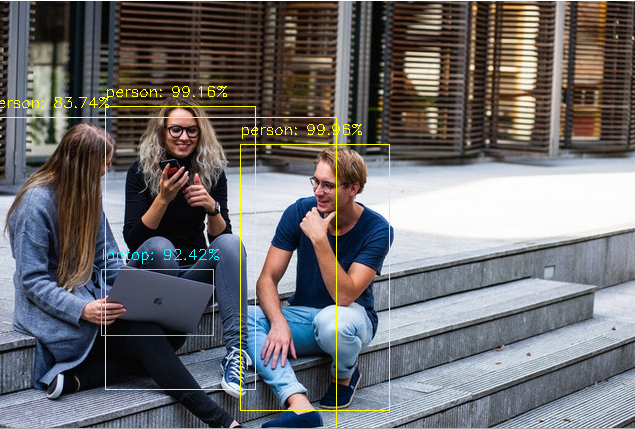